In [1]:
import sys
ROOT_DIR="Mask_RCNN-Multi-Class-Detection-master"
sys.path.append(ROOT_DIR)
from mrcnn.utils import Dataset
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn import visualize
from mrcnn import utils
import os
import json
import skimage
import glob
import matplotlib.pyplot as plt
import numpy as np
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
# import basic libraries
from os import listdir
import sys
import json
import datetime

# import advance libraries
from xml.etree import ElementTree
import skimage.draw
import cv2
import imgaug

# import keras libraries
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# ignore warnings
import warnings
import keras
warnings.filterwarnings("ignore")
%matplotlib inline

Using TensorFlow backend.


In [2]:
keras.__version__

'2.2.4'

In [3]:
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

In [4]:
# Local path to trained weights file
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [5]:
class DamageDataset(Dataset):
    def load_dataset(self, dataset_dir,json_dir, subset):
        
        # we use add_class for each class in our dataset and assign numbers to them. 0 is background
        # self.add_class('source', 'class id', 'class name')
        self.add_class("stock", 1, "c")
        self.add_class("stock", 2, "ihs")
        self.add_class("stock", 3, "hs")
        
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)        
        # load annotations using json.load()
        annotations1 = json.load(open(os.path.join(dataset_dir,json_dir)))
        
        # convert annotations1 into a list
        annotations = list(annotations1.values())  
        
        # we only require the regions in the annotations
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            
            # read image and get height and width
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]
            # extracting shape attributes and region attributes
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['stock'] for s in a['regions']]
                
            # create a dictionary {name_of_class: class_id} remember background has id 0
            name_dict = {"c": 1, "ihs": 2, "hs": 3}
            
            # all the ids/classes in a image
            num_ids = [name_dict[name] for name in objects]
            
            # you can print these ids
            # print("numids",num_ids)
            
            
            # add image to the dataset
            self.add_image(
                "stock",
                image_id=a['filename'],
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )
            
    # this function calls on the extract_boxes method and is used to load a mask for each instance in an image
    # returns a boolean mask with following dimensions width * height * instances
    def load_mask(self, image_id):
        
        # info points to the current image_id
        info = self.image_info[image_id]
        
        # for cases when source is not damage
        if info["source"] != "stock":
            return super(self.__class__, self).load_mask(image_id)
        
        # get the class ids in an image
        num_ids = info['num_ids']
        
        
        
        # we create len(info["polygons"])(total number of polygons) number of masks of height 'h' and width 'w'
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        
        for i, p in enumerate(info["polygons"]):
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

            mask[rr, cc, i] = 1
            
        # return masks and class_ids as array
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids
    
    # this functions takes the image_id and returns the path of the image
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info["source"] == "stock":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

# define a configuration for the model
class DamageConfig(Config):
    # define the name of the configuration
    NAME = "stock"
    
    # number of classes (background + damge classes)
    NUM_CLASSES = 1 + 3
    
    # number of training steps per epoch
    STEPS_PER_EPOCH = 160
    # learning rate and momentum
    LEARNING_RATE=0.002
    LEARNING_MOMENTUM = 0.8
    
    # regularization penalty
    WEIGHT_DECAY = 0.0001
    
    # image size is controlled by this parameter
    IMAGE_MIN_DIM = 512
    
    # validation steps
    VALIDATION_STEPS = 50
    
    # number of Region of Interest generated per image
    Train_ROIs_Per_Image = 200
    
    # RPN Acnhor scales and ratios to find ROI
    RPN_ANCHOR_SCALES = (16, 32, 48, 64, 128)
    RPN_ANCHOR_RATIOS = [0.5, 1, 1.5]


In [6]:
#prepare train dataset.
train_set = DamageDataset()
# change the dataset 
train_set.load_dataset('images','train.json','train')
train_set.prepare()

# prepare validation/test dataset
test_set = DamageDataset()
test_set.load_dataset('images','val.json','val')
test_set.prepare()

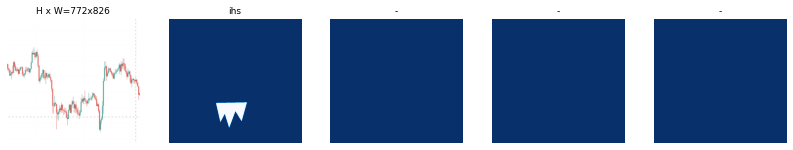

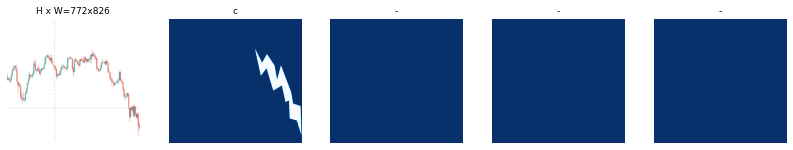

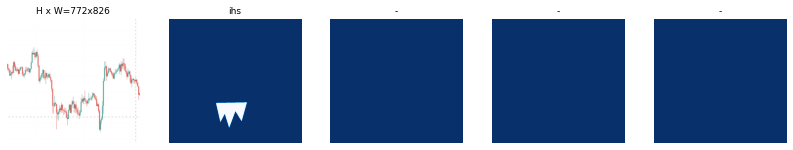

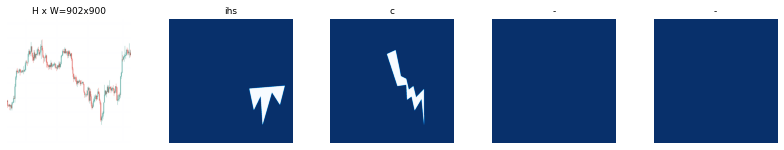

In [7]:
# Load and display random samples
image_ids = np.random.choice(train_set.image_ids, 4)
for image_id in image_ids:
    image = train_set.load_image(image_id)
    mask, class_ids = train_set.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, train_set.class_names)

In [8]:
config = DamageConfig()

# define the model
model = MaskRCNN(mode='training', model_dir='./', config=config)


model.load_weights(COCO_MODEL_PATH, 
                   by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])









Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead








In [ ]:
model.train(train_set, 
            test_set, 
            learning_rate=config.LEARNING_RATE, 
            epochs=15, 
            layers='heads')


Starting at epoch 0. LR=0.002

Checkpoint Path: ./stock20220527T1652\mask_rcnn_stock_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistribut

In [ ]:
class PredictionConfig(Config):
    NAME = "stock"
    NUM_CLASSES = 1 + 3
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
cfg = PredictionConfig()

model = MaskRCNN(mode='inference', model_dir='./', config=cfg)

model_path = 'stock20220527T1652/mask_rcnn_stock_0015.h5'
model.load_weights(model_path, by_name=True) 


In [ ]:
image = load_img("/content/images/val/Screenshot 2022-05-21 at 19.02.27.png")
image = img_to_array(image)

# call the detect method on image
results = model.detect([image], verbose=1)
r = results[0]
class_names=['background','c','ihs','hs']
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names,  r['scores'])


In [ ]:
def evaluate_model(dataset, model, cfg):
    APs = list()
    for image_id in dataset.image_ids:

        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)

        scaled_image = mold_image(image, cfg)

        sample = expand_dims(scaled_image, 0)

        yhat = model.detect(sample, verbose=0)

        r = yhat[0]

        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])

        APs.append(AP)
    maP = mean(APs)
    return maP

# TODO: create and prepare train and test dataset
# TODO: load prediction configuration with mode 'inference'
# TODO: define model
# TODO: load model weights (your trained model weights)

# evaluate model on train dataset
train_mAP = evaluate_model(train_set, model, cfg)
print(f"Train mAP: {train_mAP}")

# evaluate model on test dataset
test_mAP = evaluate_model(test_set, model, cfg)
print(f"Test mAP: {test_mAP}")